# Détéction de Fraude par carte de crédit
Aymane Mimoun \ 
2024-04-22

## Introduction
Dans ce projet, nous abordons un défi commun en apprentissage automatique : le problème de classe déséquilibrée. Nous nous concentrons spécifiquement sur l'application de l'algorithme SVM (Support Vector Machine) à la détection de fraudes, un domaine où le déséquilibre de classe est souvent rencontré.

Nous débuterons par une simulation de données illustrant le déséquilibre de classe. Ensuite, nous explorerons les implications théoriques de ce déséquilibre, avant d'examiner une solution.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("creditcard.csv")
data.head()

data = data[: 20000]

La variable contenant les classes est tranformée en facteur pour représenter les classes "fraude" et "non-fraude".

In [2]:
data['Class'] = data['Class'].astype('category')
print("Le type de la variable Class est :", data['Class'].dtype)

Le type de la variable Class est : category


In [3]:
X = data[[f'V{i}' for i in range(1, 29)]]
y = data['Class']
classe = y.value_counts().reset_index()
print("Information sur la classe à prédire :\n",classe)

Information sur la classe à prédire :
   Class  count
0     0  19915
1     1     85


On remarque que le jeu de données contient très peu de transactions frauduleuse, en effet 99 ‰ des transactions effectué sont non-frauduleuse, cela se remarque graphiquement.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


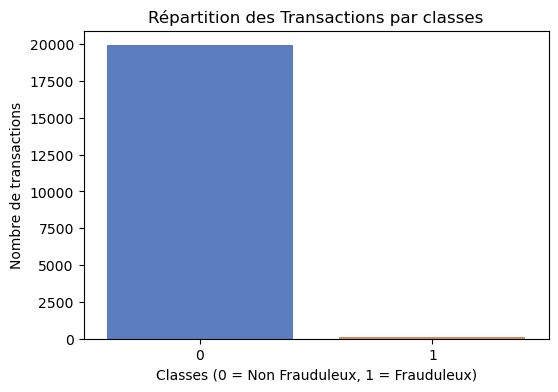

In [4]:
classe.columns = ['Class', 'Count']

plt.figure(figsize = (6, 4))
sns.barplot(x = 'Class', y = 'Count', data=classe, palette = "muted")
plt.title('Répartition des Transactions par classes')
plt.xlabel('Classes (0 = Non Frauduleux, 1 = Frauduleux)')
plt.ylabel('Nombre de transactions')
plt.show()

Un graphique est créé pour visualiser la répartition des montants de transactions en fonction de la classe afin de verifier si les fraude sont effetué sur des gros montants.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


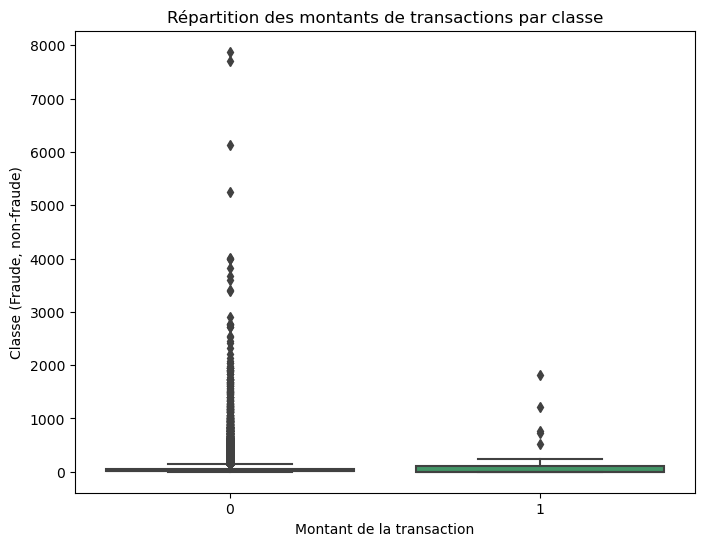

In [5]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'Class', y = 'Amount', data = data, palette = "BuGn")
plt.title("Répartition des montants de transactions par classe")
plt.xlabel('Montant de la transaction')
plt.ylabel('Classe (Fraude, non-fraude)')
plt.show()

Il est frappant de noter que la majorité des transactions frauduleuses sont de faibles montants. Cela pourrait indiquer que les fraudeurs adoptent des stratégies ciblant des montants plus faibles pour éviter d'attirer l'attention des systèmes de sécurité.

De plus, une inspection préliminaire des données révèle un déséquilibre marqué entre les classes, il sera necéssaire d'utiliser les bonnes métriques pour améliorer le modèle de prédiction.



### Normalisation des données

In [6]:
X = StandardScaler().fit_transform(X)

## Entrainement du modèle

Ensuite, les données sont divisées en ensembles d'entraînement et de test. Un modèle SVM est entraîné sur les données d'entraînement initiales.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

svm_model = svm.SVC(kernel = "linear").fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)
mat = confusion_matrix(y_test, y_pred)

In [8]:
print(f'Précision du modèle : {acc}')
print(f'Rapport de classification :\n {classification}')

Précision du modèle : 0.99875
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3983
           1       0.93      0.76      0.84        17

    accuracy                           1.00      4000
   macro avg       0.96      0.88      0.92      4000
weighted avg       1.00      1.00      1.00      4000




Bien que la précision globale soit satisfaisante, le F1-score semble faible pour la classe "Fraude", ce qui indique un rappel et une précision insuffisants.

In [9]:
print(f'Matrice de confusion : \n {mat}')

Matrice de confusion : 
 [[3982    1]
 [   4   13]]


Nous constatons que notre modèle a du mal à détecter les fraudes, avec un nombre significatif de transactions frauduleuses classées à tort comme légitimes. 

On a 25% de de transaction frauduleuse classé comme légale, ce qui est très contraignant.


## Explication théorique
On peut observer le déséquilibre de classe en observant les probabilités liées à chaque classe dans un ensemble de données.

Supposons que nous ayons un problème de classification binaire avec deux classes, positif (1) et négatif (0). 

Soit $P(Y=1)$ la probabilité d'observation d'un exemple de la classe positive, et $P(Y=0)$ la probabilité d'observation d'un exemple de la classe négative. Dans un ensemble de données équilibré, ces probabilités seraient égales ou similaires, c'est-à-dire que $P(Y=1)\approx P(Y=0)$

En présence d'un déséquilibre de classe, une classe peut être beaucoup plus fréquente que l'autre, ce qui implique que $P(Y=1)$ et $P(Y=0)$ sont très différents.

Les algorithmes de classification sont confrontés à ce problème, car ils sont souvent influencés par la fréquence des classes lors de leur apprentissage. La plupart du temps, si une classe est beaucoup plus répandue que l'autre, le modèle peut avoir tendance à prédire cette classe majoritaire, ignorant ainsi la classe minoritaire.

Une explication plus quantitative : 

Le modèle va avoir tendance à prédire la classe majoritaire, on a donc un classifieur qui retournera toujours la classe majoritaire. Notons là la N-ème.

Alors la probabilité $ P(Y=y, c(X)=N)=P(Y=y)$ et donc le risque du déséquilibre se note :

$R=\sum_{y=1}^{N}l(y, N)P(Y=y, c(X)=N)=\sum_{y=1}^{N}l(y, N)P(Y=y) \\ 
=\sum_{y=1}^{N} 1_{y\neq N}P(Y=y)=1-P(Y=N)$

On remarque d'après le resultat que : $ P(Y=N)=1-R\approx 1$.
Cela signifie essentiellement que le risque est proche de 1 lorsque la classe majoritaire est toujours prédite.


## Réequilibrage des données : sur-échantillonage

Pour résoudre le problème de déséquilibre de classe, une technique de suréchantillonnage est utilisée avec la fonction ROSE. Le sur-échantillonage nous permet de rééquilibré les classes.

Répartition des classes après SMOTE : Counter({0: 15932, 1: 15932})


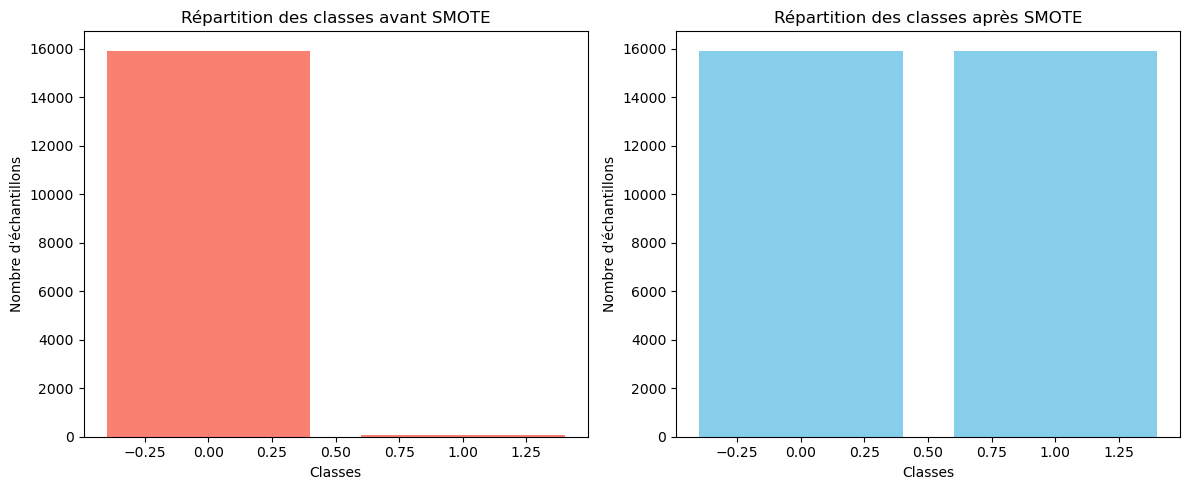

In [10]:
smote = SMOTE()
from collections import Counter
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

counter_before = Counter(y_train)
counter_after = Counter(y_train_smote)

print("Répartition des classes après SMOTE :", counter_after)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(counter_before.keys(), counter_before.values(), color='salmon')
ax[0].set_title('Répartition des classes avant SMOTE')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Nombre d\'échantillons')
ax[1].bar(counter_after.keys(), counter_after.values(), color='skyblue')
ax[1].set_title('Répartition des classes après SMOTE')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Nombre d\'échantillons')

plt.tight_layout()
plt.show()

In [11]:
model_svm = svm.SVC(kernel = "linear").fit(X_train_smote, y_train_smote)

In [12]:
y_pred = model_svm.predict(X_test)

acc_smote = accuracy_score(y_test, y_pred)
classification_smote = classification_report(y_test, y_pred)
mat_smote = confusion_matrix(y_test, y_pred)

In [13]:
print(f'Précision du modèle après Sur-échantillonage : {acc_smote}')
print(f'Rapport de classification :\n {classification_smote}')


Précision du modèle après Sur-échantillonage : 0.98625
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3983
           1       0.23      0.94      0.37        17

    accuracy                           0.99      4000
   macro avg       0.61      0.96      0.68      4000
weighted avg       1.00      0.99      0.99      4000



In [14]:
print(f'Matrice de confusion :\n {mat_smote}')

Matrice de confusion :
 [[3929   54]
 [   1   16]]


Bien que la précision soit inférieure à celle du modèle précédent, on observe une réduction des faux positifs, passant de 8 à 1. Cependant, le nombre de faux négatifs a également augmenté. Il reste néanmoins préférable de classer par erreur des transactions non frauduleuses comme frauduleuses plutôt que l'inverse, car cela présente un risque moindre.

## Validation croisée

Ensuite, une validation croisée est effectuée pour sélectionner le meilleur modèle SVM.

In [30]:
skf = StratifiedKFold(n_splits = 5)

scoring = cross_val_predict(model_svm, X_train_smote, y_train_smote, cv = skf)


In [33]:
acc_smote_cv = accuracy_score(y_train_smote, scoring)
classification_smote_cv = classification_report(y_train_smote, scoring)
mat_smote_cv = confusion_matrix(y_train_smote, scoring)


In [34]:
print("Précision avec validation croisée : ", acc_smote_cv)
print("Rapport de classification (validation croisée) :\n", classification_smote_cv)


Précision avec validation croisée :  0.9936919407481798
Rapport de classification (validation croisée) :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     15932
           1       0.99      1.00      0.99     15932

    accuracy                           0.99     31864
   macro avg       0.99      0.99      0.99     31864
weighted avg       0.99      0.99      0.99     31864



In [35]:
print("Matrice de confusion (validation croisée) :\n", mat_smote_cv)

Matrice de confusion (validation croisée) :
 [[15731   201]
 [    0 15932]]


Après validation croisée, notre modèle a atteint une précision de 99,37 %, avec un rappel de 100 % pour les transactions frauduleuses, ce qui témoigne de son efficacité remarquable dans l'identification des fraudes tout en maintenant un faible taux de faux positifs.

## Conclusion 
Dans ce projet, nous avons examiné le problème du déséquilibre de classe dans le cadre de la détection de fraudes en utilisant l'algorithme SVM. À travers des simulations de données, nous avons visualisé et compris l'impact significatif du déséquilibre de classe sur la performance de l'algorithme SVM. En explorant les implications théoriques de ce problème, nous avons approfondi notre compréhension des problèmes rencontrés par les algorithmes de classification dans de telles situations.

ce projet souligne l'importance de la gestion du déséquilibre de classe en Machine Learning. En reconnaissant ce problème et en explorant des solutions appropriées, nous pouvons développer des modèles de classification plus robustes et plus efficaces.

## References 
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

https://lrouviere.github.io/INP-HB/cours_don_des.pdf

https://towardsdatascience.com/the-complete-guide-to-support-vector-machine-svm-f1a820d8af0b